# Bulding a book recommender system using collaborative filtering

In this notebook, I will create a script to recommend books using the data about other users' ratings of books from Goodreads. As a basis, I will follow the guidelines suggested by Vik Paruchuri, founder of Dataquest, in this [video](https://www.youtube.com/watch?v=mrWzQy_Lddc&list=PL6UJrXaOPPcEesMFPaieQJwnBvKiRH2tT). I really enjoyed this project walkthrough and tried to implement my project along similar lines. I also added some tweaks that I hope made the workflow more robust and results more relevant to the main task, i.e. recommending books to a user based on his/her book ratings.

In this project, I used the same [UCSD Book Graph datasets](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home) that were analyzed in the video referenced above. The full body of datasets was collected in late 2017. In this project, I used the following datasets:
* [goodreads_books.json.gz](https://drive.google.com/uc?id=1LXpK1UfqtP89H1tYy0pBGHjYk8IhigUK) - complete information about the books available on Goodreads
* [goodreads_book_authors.json](https://drive.google.com/uc?id=19cdwyXwfXx_HDIgxXaHzH0mrx8nMyLvC) - information about book authors
* [goodreads_interactions.csv](https://drive.google.com/open?id=1zmylV7XW2dfQVCLeg1LbllfQtHD2KUon) - book ratings by users
* [book_id_map.csv](https://drive.google.com/uc?id=1CHTAaNwyzvbi1TR08MJrJ03BxA266Yxr) - dataset mapping book ids in the *goodreads_books* dataset to their Goodreads book ids

I implemented the project in several steps:
1. Collected, analyzed, and organized the data about the books available on Goodreads
2. Got the information about books that I read or would like to read from my Goodreads cabinet
3. Using the dataset about Goodreads users' book ratings, identified top 15 users that are most similar to my reading preferences
4. Selected the books with the highest average ratings and the highest number of ratings by the users most similar to me
5. Removed the books that I have already read or that are on my to-read list

As a result, I got the books that were recommended to me.

In [1]:
#importing the necessary libraries and amending display settings
import numpy as np
import pandas as pd
import csv
import gzip
import json
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.style.use('Solarize_Light2')
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize': (9, 6)})

After importing necessary libraries, I read the goodreads_books dataset. To create a dataframe, I used the following book features: book_id (unique number of a book edition assigned by Goodreads), work_id (more on it later), book title, book author, book average rating, and number of ratings. As the *goodreads_books* dataset is fairly large, I iterated over each element of its to get only the neecessary information about the books.

In [2]:
#getting basic info about all books in the dataset

book_ids = []
work_ids = []
titles = []
authors = []
avg_ratings = []
nums_ratings = []

with gzip.open('data\goodreads_books.json.gz', 'r') as f:
    
    for line in tqdm(f):
        
        book_dict = json.loads(line)

        num_ratings_str = book_dict['ratings_count']
        if num_ratings_str != '':
            num_ratings = float(num_ratings_str)
        else:
            num_ratings = np.nan

        book_id = int(book_dict['book_id'])

        work_id_str = book_dict['work_id']
        if work_id_str != '':
            work_id = float(work_id_str)
        else:
            work_id = np.nan

        title = book_dict['title']

        author_list = book_dict['authors']
        if len(author_list) > 0:
            author = author_list[0]['author_id']
        else:
            author = np.nan

        avg_rating_str = book_dict['average_rating']
        if avg_rating_str != '':
            avg_rating = float(avg_rating_str)
        else:
            avg_rating = np.nan
                
        book_ids.append(book_id)
        work_ids.append(work_id)
        titles.append(title)
        authors.append(author)
        avg_ratings.append(avg_rating)
        nums_ratings.append(num_ratings)

all_books = pd.DataFrame({
    'book_id': book_ids,
    'work_id': work_ids,
    'title': titles,
    'author': authors,
    'avg_rating': avg_ratings,
    'num_ratings': nums_ratings
})

2360655it [01:58, 19990.48it/s]


In [3]:
#checking the length of the dataframe
print(f'There are {len(all_books):,} rows in the all_books dataframe.')

#checking the percentage of missing values in the dataframe
print('\nDistribution of missing values in the dataframe')
all_books.isna().sum()

There are 2,360,655 rows in the all_books dataframe.

Distribution of missing values in the dataframe


book_id          0
work_id        524
title            0
author         537
avg_rating     524
num_ratings    524
dtype: int64

The resulting dataframe has some missing values. Since there are very few of them and the books they relate to are not very popular, I dropped the corresponding rows. Also, book authors are coded as numbers, but I will map them to author names later.

In [4]:
#dropping rows with missing info about book ratings
all_books.dropna(subset=['avg_rating', 'num_ratings'], inplace=True)

#casting work_id column as integer
all_books.work_id = all_books.work_id.astype(int)

#dropping rows with missing titles
all_books = all_books[~all_books.title.isin(['', 'N/A'])]

all_books.head()

,book_id,work_id,title,author,avg_rating,num_ratings
0,5333265,5400751,W.C. Fields: A Life on Film,604031,4.00,3.00
1,1333909,1323437,Good Harbor,626222,3.23,10.00
2,7327624,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",10333,4.03,140.00
3,6066819,6243154,Best Friends Forever,9212,3.49,51184.00
4,287140,278577,Runic Astrology: Starcraft and Timekeeping in ...,149918,3.40,15.00


Importantly, there can be numerous different Goodread pages about the same book, due to different editions and translations of a book. That's why the dataframe can have more than one row for a single book. Fortunately, the dataset I used has a separate work_id for each book that accounts for different editions of the same book. To match Goodreads book_ids with dataset work_ids, I created a dictionary.

In [5]:
#displaying all editiond of the first Harry Potter book
all_books[all_books.work_id==4640799]

,book_id,work_id,title,author,avg_rating,num_ratings
3221,27421523,4640799,Harry Potter and the Sorcerer's Stone (Harry P...,1077326,4.45,80.00
9991,6015185,4640799,"Harry Potter och de vises sten (Harry Potter, #1)",1077326,4.45,96.00
14794,35427227,4640799,Harry Potter and the Philosopher's Stone,1077326,4.45,7.00
15382,25878460,4640799,Harry Potter and the Sorcerer's Stone (Harry P...,1077326,4.45,8.00
28639,29546094,4640799,"ჰარი პოტერი და ფილოსოფიური ქვა (ჰარი პოტერი, #1)",1077326,4.45,13.00
...,...,...,...,...,...,...
2352241,2200815,4640799,"Harry Potter och de vises sten (Harry Potter, #1)",1077326,4.45,47.00
2353153,27838766,4640799,Harry Potter and the Philosopher's Stone (Harr...,1077326,4.45,39.00
2356456,3356,4640799,Harry Potter y la piedra filosofal (Harry Pott...,1077326,4.45,15.00
2357081,12004870,4640799,Harry Potter Y La Piedra Filosofal,1077326,4.45,49.00


In [6]:
#creating dictionary mapping books ids to work ids
book_work_id_dict = dict(zip(all_books.book_id, all_books.work_id))

Next, I created a functions that combines all information about various editions of a single book in one row. I then iterated over the *all_books* dataframe to create a new, compressed dataframe, titled *all_books_compressed*. It includes information about its book_ids, work_id, title, author, average rating, and total number of ratings.

In [7]:
#function for combining different pages about the same book into one row

def collapse_book_rows(work):

    all_values = []

    if len(work) == 1:
        all_values.append(work.book_id.item())
    else:
        all_values.append(work.book_id.values)
        
    all_values.append(work.work_id.iloc[0])
    all_values.append(work.title.iloc[0])
    all_values.append(work.author.iloc[0])
    all_values.append(work.avg_rating.iloc[0])
    all_values.append(np.sum(work.num_ratings.values))

    return np.asarray(all_values, dtype=object)


In [8]:
unique_ids = all_books.work_id.unique()
df_index = range(0, len(unique_ids))
df_columns = all_books.columns
all_books_compressed = pd.DataFrame(columns=df_columns, index=df_index)

for i, unique_id in tqdm(enumerate(unique_ids)):
    work = all_books[all_books.work_id==unique_id].sort_values('num_ratings', ascending=False)
    work_row = collapse_book_rows(work)
    all_books_compressed.loc[i] = work_row

1521953it [1:11:42, 353.75it/s]


After combining rows with the data about similar books, I kept only those books that have 10 ratings or more. I also stored their book_ids for later use.

In [21]:
#keeping only books with at least 10 ratings
all_books_compressed = all_books_compressed[all_books_compressed.num_ratings >= 10]
all_books_ids = np.hstack(all_books_compressed.book_id.values)

#removing books with average rating of 0
all_books_compressed = all_books_compressed[all_books_compressed.avg_rating != 0]

all_books_compressed.head()

,book_id,work_id,title,author,avg_rating,num_ratings
1,"[25717, 6608131, 769661, 2050273, 942972, 1333...",1323437,Good Harbor,626222,3.23,6202.00
2,7327624,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",10333,4.03,140.00
3,"[6066819, 6587902, 6723239, 7014718, 5887988, ...",6243154,Best Friends Forever,9212,3.49,53117.00
4,287140,278577,Runic Astrology: Starcraft and Timekeeping in ...,149918,3.40,15.00
5,287141,278578,The Aeneid for Boys and Girls,3041852,4.13,46.00


Below, you can see the distribution of book ratings from the dataset.

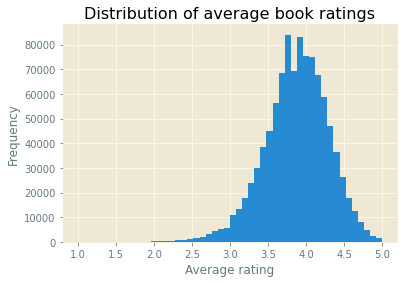

In [22]:
all_books_compressed.avg_rating.plot.hist(bins=50)

plt.title('Distribution of average book ratings')
plt.xlabel('Average rating')

plt.show()

In [23]:
all_works_number = len(all_books_compressed)
print(f'There are {all_works_number:,} unique books in the dataset.')

There are 998,620 unique books in the dataset.


Having all the necessary aggregate information about Goodreads books, I needed to use the *goodreads_interactions* dataset to select the user with preferences that are most similar to mine. Before that, though, I collected information about my own book ratings and books on my to-read list. To get this info, I exported the data from my Goodreads cabinet.

Many book titles on Goodreads include information about book series they belong to. Sometimes, these book series are spelled differently although relate to the same collection of books. To account for possible discrepancies in titles of the same book, I created a combination of clean book titles, without references to book series, and their authors. I will use the resulting set later, when I will need to remove the books I have read or plan to read from the list of recommended books.

In [24]:
#reading the dataset from my Goodreads profile
my_books = pd.read_csv('data/my_books.csv')

#storing the combination of titles without series info and authors into a set
remove_collection_pattern = '\s\([^)]*\)*(?!.*\()' #pattern for removing series info from book title
my_books['title_clean'] = my_books.Title.str.replace(remove_collection_pattern, '', regex=True)
my_books_combinations = set(zip(my_books.title_clean, my_books.Author))

Below are the top rows of the dataframe of my Goodreads books. The rating of 0 denotes that a book is on my to-read list.

In [25]:
my_books.head()

,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Read Count,Recommended For,Recommended By,Owned Copies,Original Purchase Date,Original Purchase Location,Condition,Condition Description,BCID,title_clean
0,4682558,The Book of Night Women,Marlon James,"James, Marlon",NaN,"=""1594488576""","=""9781594488573""",3,4.38,Riverhead Books,...,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,The Book of Night Women
1,58730652,Paradais,Fernanda Melchor,"Melchor, Fernanda",Sophie Hughes,"=""1913097870""","=""9781913097875""",0,3.76,Fitzcarraldo Editions,...,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Paradais
2,46041168,Hurricane Season,Fernanda Melchor,"Melchor, Fernanda",Sophie Hughes,"=""0811228037""","=""9780811228039""",4,4.10,New Directions,...,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Hurricane Season
3,7779571,To the End of the Land,David Grossman,"Grossman, David",Jessica Cohen,"=""0307592979""","=""9780307592972""",0,4.00,Vintage Books,...,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,To the End of the Land
4,49151032,On Fragile Waves,E. Lily Yu,"Yu, E. Lily",NaN,"=""1645660095""","=""9781645660095""",3,4.14,Erewhon,...,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,On Fragile Waves


From the dataframe above, I created another one with the information only about my ratings and the corresponsing book_ids and work_ids.

In [26]:
#creating a dataframe with ratings and ids of my books
my_ratings = my_books[['Book Id', 'My Rating']]
my_ratings = my_ratings.rename(columns={'Book Id': 'book_id', 'My Rating': 'rating'})
my_ratings['work_id'] = my_ratings.book_id.map(book_work_id_dict)
my_ratings['user_id'] = -1 #setting my user_id

#storing book ids and work ids of my books 
my_ratings_book_ids = set(my_ratings.book_id.values)
my_ratings_work_ids = set(my_ratings.work_id.values)

my_ratings.head()

,book_id,rating,work_id,user_id
0,4682558,3,4733113.00,-1
1,58730652,0,NaN,-1
2,46041168,4,NaN,-1
3,7779571,0,10698979.00,-1
4,49151032,3,NaN,-1


Some of the books from my Goodreads bookshelf do not have work_id as these books or specific editions of them that I rated were published after the UCSD Book Graph datasets were collected.

In the *goodreads_interactions* dataset, book_ids are different from those used on Goodreads website. To map them to the Goodreads book_ids, I used another dataset, *book_id_map*, and created a dictionary.

In [27]:
#creating dictionary mapping books ids in the dataset to their goodreads ids
book_id_map = pd.read_csv('data/book_id_map.csv')
book_id_map_dict = dict(zip(book_id_map.book_id_csv, book_id_map.book_id))

Next, I iterated over the *goodreads_interactions* dataset with information of book ratings by users to find ids of only those users that read or planned to read at least one book from my Goodreads booklist. Next, I limited the set of users to only those who rated or marked as to-read at least 20% of the books from my book collection.

This was done for two resaons. First, it would be simpler and faster to find similar users among those who have met some basic threshold of similarity. Second, as the *goodreads_interactions* is quite large (more than 4 Gb), creating a user-book matrix and further calculation of similarity scores would be too computationally expensive.

In [28]:
#iterating over the goodreads interactions dataset to find overalpping users

overlapping_users = {}
user_count = []

with open('data\goodreads_interactions.csv', 'r') as f:

    reader = csv.reader(f, delimiter=',')
    next(reader, None) #skipping the header row

    for row in tqdm(reader):
        
        user_id = int(row[0])
        book_id = book_id_map_dict[int(row[1])]

        if book_id in my_ratings_book_ids:

            if user_id in overlapping_users:
                overlapping_users[user_id] += 1
            else:
                overlapping_users[user_id] = 1

        user_count.append(user_id)

unique_user_count = set(user_count)
unique_user_num = len(unique_user_count)

print(f'There are {unique_user_num:,} unique users in the dataset.')


228648342it [05:10, 735387.45it/s]


There are 876,145 unique users in the dataset.


In [29]:
num_my_books = len(my_ratings_book_ids)
overlapping_users_filtered = {user: num for user, num in overlapping_users.items() if num > (num_my_books * 0.2)}

overlapping_users_num = len(overlapping_users)
overlapping_users_filtered_num = len(overlapping_users_filtered)
print(f'{overlapping_users_num:,} users read or want to read at least one book from my Goodreads booklist')
print(f'{overlapping_users_filtered_num:,} users read or want to read at least 20% of the books from my Goodreads booklist')

486,794 users read or want to read at least one book from my Goodreads booklist
1,223 users read or want to read at least 20% of the books from my Goodreads booklist


After selecting the users with some level of similarity to me, I iterated over the *goodreads_interactions* dataset again to create a dataframe with book ratings of only these users.

In [30]:
#creating dataframe with user-book interactions

user_ids = []
book_ids = []
ratings = []

with open('data\goodreads_interactions.csv', 'r') as f:

    reader = csv.reader(f, delimiter=',')
    next(reader, None) #skipping the header row

    for row in tqdm(reader):
        
        user_id = int(row[0])

        if user_id in overlapping_users_filtered:
            
            book_id = book_id_map_dict[int(row[1])]     
            rating = int(row[3])
            
            user_ids.append(user_id)
            book_ids.append(book_id)
            ratings.append(rating)

interactions = pd.DataFrame({
    'user_id': user_ids,
    'book_id': book_ids,
    'rating': ratings
})

228648342it [03:02, 1250070.15it/s]


As a next step, I concatenated the dataframes with books ratings of similar users and me and kept only ratings of those books that have at least 10 ratings in total. I also removed all 0 ratings as they denote that users didn't read the book. In addition, I removed duplicate ratings, i.e. when a user rated different editions of the same book more than once. In these cases, I removed all ratings except for the last.

In [31]:
#adding my ratings to the dataframe
all_interactions = pd.concat([interactions, my_ratings], ignore_index=True)

#subsetting only those books that have 10 or more ratings
all_interactions = all_interactions[all_interactions.book_id.isin(all_books_ids)]

#removing all rows without actual ratings
all_interactions = all_interactions[all_interactions.rating > 0]

#adding work_id column
all_interactions['work_id'] = all_interactions.book_id.map(book_work_id_dict)
all_interactions.drop(columns='book_id', inplace=True)

#dropping duplicate ratings for the same book
all_interactions = all_interactions.drop_duplicates(['user_id', 'work_id'], keep='last')

all_interactions.head()

,user_id,rating,work_id
0,364,3,16171
1,364,5,3138328
2,364,4,3143431
3,364,2,3249453
4,364,5,810663


The distribution of book ratings in the final user-book interactions dataframe is visualized below.

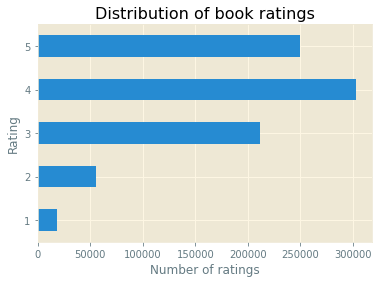

In [32]:
all_interactions.rating.value_counts().sort_index().plot.barh()

plt.title('Distribution of book ratings')
plt.xlabel('Number of ratings')
plt.ylabel('Rating')

plt.show()

To find the most similar users to me, I needed to transform the user-book interactions dataframe into a matrix with the number of rows equaling to the number of unique users and the number of columns to the number of unique books. Since any given user rated only small percentage of all books, the resulting matrix will contain a lot of missing values. Following the advice by Vik Paruchuri in his video, I created a sparse matrix for this purpose.

In [33]:
#coding the user_id and work_id columns
all_interactions['user_index'] = all_interactions.user_id.astype('category').cat.codes
all_interactions['work_index'] = all_interactions.work_id.astype('category').cat.codes

#creating a sparse matrix
interactions_coo = coo_matrix((all_interactions.rating, (all_interactions.user_index, all_interactions.work_index)))
interactions_csr = interactions_coo.tocsr()

interactions_csr

<1217x203992 sparse matrix of type '<class 'numpy.int64'>'
	with 838174 stored elements in Compressed Sparse Row format>

After creating the sparse matrix, I identified 15 similars who have the most similar book ratings to mine, using cosine similarity measure. I also stored the indices of these top 15 users and the corresponding similarity scores in a dictionary.

I then selected only the ratings made by these users and calculated their average ratings per each book. However, instead of simple average, I used weighted average, by weighting the ratings made be each user by his/her similarity score. In other words, the ratings of users with higher similarity score had more weight than the ratings made by users with lower similarity scores. As a result, weighted average of the ratings of a given book was influenced more by the ratings of users more similar to me.

In [34]:
#getting 15 users with the most similar ratings to mine
similarities = cosine_similarity(interactions_csr[0, :], interactions_csr).flatten()
top_15_similar_indices = np.delete(np.argpartition(similarities, -16)[-16:], -1) #removing myself from the similar users list
similar_users = all_interactions[all_interactions.user_index.isin(top_15_similar_indices)]

#matching similarity scores to the top 15 similar users
user_similarity_dict = dict(zip(top_15_similar_indices, similarities[top_15_similar_indices]))
similarity_scores = similar_users.user_index.map(user_similarity_dict).values
similar_users.insert(5, 'similarity_score',  similarity_scores)

#adding weighted rating column
weighted_ratings = similar_users.rating * similar_users.similarity_score
similar_users.insert(6, 'weighted_rating',  weighted_ratings)

The similarity score of the top 15 most similar to me users are shown below.

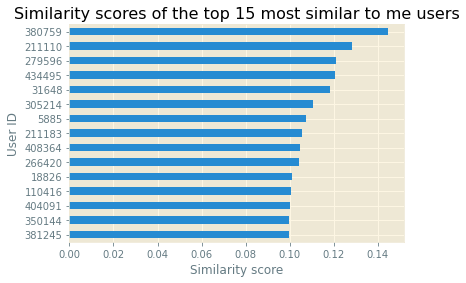

In [35]:
similar_users.groupby('user_id').similarity_score.min().sort_values().plot.barh()

plt.title('Similarity scores of the top 15 most similar to me users')
plt.xlabel('Similarity score')
plt.ylabel('User ID')

plt.show()

After getting weighted average for all book rtaings, I kept only those books which had weighted averages of at least 4 (out of 5) and was rated by at least 5 (out of 15) users.

In [36]:
#getting average weighted rating for each work
rec_books = similar_users.groupby('work_id').agg({'weighted_rating': ['sum', 'count'], 'similarity_score': 'sum'})
rec_books['avg_weighted_rating'] = rec_books.weighted_rating['sum'] / rec_books.similarity_score['sum']
rec_books['rating_count'] = rec_books.weighted_rating['count']
rec_books = rec_books[['avg_weighted_rating', 'rating_count']]
rec_books.columns = rec_books.columns.get_level_values(0) #flattening the columns

#removing the books from my list
rec_books = rec_books[~rec_books.index.isin(my_ratings_work_ids)]

#keeping only books with average weighted rating greater than or equal to 4 and more than 5 ratings
rec_books = rec_books[(rec_books.avg_weighted_rating >= 4) & (rec_books.rating_count >= 5)]

rec_books.head()

,avg_weighted_rating,rating_count
work_id,,
40283,4.04,8
69741,4.21,9
153313,4.34,12
221359,4.40,5
234915,4.02,5


Finally, I needed to get information for each of the recommended books and also check for any books in the recommended list that were also present in my Goodreads booklist. First, I merged the recommended books dataframe with the general Goodreads books dataframe to get the info about the books' titles and authors. Second, I removed all books from the recommended books dataframe that had the same combinations of titles and authors that were also present in my books dataframe.

In [37]:
#creacting a dictionary mapping author ids to author names

author_id_dict = {}

with gzip.open('data\goodreads_book_authors.json.gz', 'r') as f:
    
    for line in f:
        
        book_dict = json.loads(line)

        author_id = int(book_dict['author_id'])
        author_name = book_dict['name']

        author_id_dict[author_id] = author_name

In [40]:
#getting titles and other details of recommended books
rec_books_merged = pd.merge(all_books_compressed, rec_books, how='inner', on='work_id').sort_values('avg_weighted_rating', ascending=False)

#removing books that are in the list of my books
rec_books_merged['title_clean'] = rec_books_merged.title.str. replace(remove_collection_pattern, '', regex=True)
rec_books_merged['author'] = rec_books_merged.author.astype(int).map(author_id_dict) 
rec_books_merged['title_author'] = list(zip(rec_books_merged.title_clean, rec_books_merged.author))
rec_books_merged = rec_books_merged[~rec_books_merged.title_author.isin(my_books_combinations)]

#dropping unnecessary columns
rec_books_merged = rec_books_merged[['title', 'author', 'avg_weighted_rating', 'rating_count']].reset_index(drop=True)

The final dataframe with the basic information about the recommended books is presented below.

In [41]:
rec_books_merged

,title,author,avg_weighted_rating,rating_count
0,One Flew Over the Cuckoo's Nest,Ken Kesey,4.68,6
1,If on a Winter's Night a Traveler,Italo Calvino,4.59,5
2,The God of Small Things,Arundhati Roy,4.58,9
3,Beloved,Toni Morrison,4.55,5
4,Possession,A.S. Byatt,4.50,6
5,The Secret History,Donna Tartt,4.40,5
6,"Catch-22 (Catch-22, #1)",Joseph Heller,4.38,8
7,The House of the Spirits,Isabel Allende,4.37,5
8,War and Peace,Leo Tolstoy,4.36,5
9,1984,George Orwell,4.34,12


Overall, I am satisfied with the results. Impressively, the number one recommended book for was *One Flew Over the Cuckoo's Nest*, which in fact is one of my all-time favorites, although I haven't rated it on Goodreads. There are some classics most of which I also have read (but also haven't rated), but there are many contemprorary books I haven't heard of or haven't considered reading. I will definitely check them out.

In the next notebook, I'm going to use machine learning algorithms to improve the recommendations further. I will also use train-test split and validation techniques to evaluate errors of predicted ratings before making the final predictions.